In [1]:
%matplotlib inline
import scipy.io as sio
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn import cross_validation as cv
import pandas as pd
import cPickle as cp

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/u.data', sep='\t', names=header)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)

Number of users = 943 | Number of movies = 1682


In [3]:
train_data, test_data = cv.train_test_split(df,test_size=0.25)
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
print df.head()

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [4]:
"""Matrix for a user and all items.(train data)"""
def data_fill(data,x):
    for i in data.itertuples(): 
        x[i[1]-1,i[2]-1] = i[3]   #Filling the matrix from data frame.
    return x

rate_train = np.zeros((n_users,n_items))
rate_test = np.zeros((n_users,n_items))		#Similarly do for test data.

rate_train = data_fill(train_data,rate_train)
rate_test = data_fill(test_data,rate_test)     
""" Here both test, train matrices have same shapes.There are missing values in both(not rated movies by a particular user). 
    Objective is used to predict the values of those movies.
    df.size < x.size  -> df only has movies and users 'with' ratings."""

" Here both test, train matrices have same shapes.There are missing values in both(not rated movies by a particular user). \n    Objective is used to predict the values of those movies.\n    df.size < x.size  -> df only has movies and users 'with' ratings."

epoch 1 =>  36.09695217 62.3612116339
epoch 11 =>  25.8139327945 44.8891875876
epoch 21 =>  25.2006121287 43.8817772669
epoch 31 =>  23.9646312466 41.7694186861
epoch 41 =>  22.752061154 39.6911017674
epoch 51 =>  21.7371818926 37.9512559234
epoch 61 =>  20.9262082678 36.5614599636
epoch 71 =>  20.2834414636 35.460464826
epoch 81 =>  19.7699336114 34.5813178356
epoch 91 =>  19.3537881156 33.8691905215
epoch 101 =>  19.0110424295 33.2829102723
epoch 111 =>  18.72412454 32.792301413
epoch 121 =>  18.4801646521 32.375276157
epoch 131 =>  18.269676642 32.0155633411
epoch 141 =>  18.085610477 31.7010769067
epoch 151 =>  17.9226821169 31.4227627878
epoch 161 =>  17.7768980173 31.1737811762
epoch 171 =>  17.6452154774 30.9489227713
epoch 181 =>  17.5252985464 30.744189516
epoch 191 =>  17.415341408 30.5564914036
epoch 201 =>  17.3139392585 30.3834249247
epoch 211 =>  17.2199923681 30.2231085334
epoch 221 =>  17.1326332374 30.0740577867
epoch 231 =>  17.051169993 29.9350883887
epoch 241 =>  16

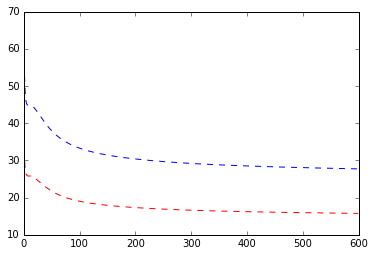

In [5]:
"""
    If a rating is present (1-5), then mark that movie by that user as 1.
    Else mark it as 0,indicating no rating.
""" 
def get_indices(a):
    k = a.copy()
    k[k > 0] = 1
    k[k == 0] = 1
    return k

def prediction(a,b):
    return np.dot(a.T,b)

def rms(ind,x,q,p):
    return np.sqrt(abs(np.sum((ind * (x - prediction(p,q)))**2)/len(x[x > 0]))) # len(R[R>0]) consider only those having rating

def grad_prediction(alpha,lamba,n_epochs,rate_train,rate_test):
    m,n = rate_train.shape  #No of Users, Items
    no_genres = 19 # No of genres
    theta = 3* np.random.rand(no_genres,m) #user parameters
    x = 3* np.random.rand(no_genres,n) #Features 
    
    train_index = get_indices(rate_train)
    test_index = get_indices(rate_test)
    
    train_error = []
    test_error = []

    users,items = rate_train.nonzero() #only for those having rating -> outputs the indices of non zero elements(row and collumn).
    
    for epoch in range(n_epochs):
        if epoch %10 ==0:
            print "epoch "+str(epoch+1)+" => ",
        for u,i in zip(users,items):
            e = rate_train[u,i] - prediction(theta[:,u],x[:,i])
            theta[:,u] += alpha *(e * x[:,i] -lamba *theta[:,u])
            x[:,i] += alpha *(e * theta[:,u] - lamba * x[:,i])
            
        train_rms = rms(train_index,rate_train,x,theta)
        test_rms = rms(test_index,rate_test,x,theta)
        
        train_error.append(train_rms)
        test_error.append(test_rms)
        if epoch %10 == 0:
            print train_error[-1],test_error[-1]
    
    plt.plot(train_error,'r--',test_error,'b--')
    plt.show()
    return [prediction(theta,x),theta,x]

res = grad_prediction(0.01,0.1,600,rate_train,rate_test) #Learning rate,reg_factor,n_epochs,train & test set.

In [7]:
class mod():
    def __init__(self,res):
        self.pred = res[0]
        self.user_para = res[1]
        self.features = res[2]    

model =  mod(res)
with open('./data/model.pkl','wb') as g:
    cp.dump(model,g)
